In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.rcParams["figure.figsize"] = [10, 5]

df=pd.read_csv('df_file.csv')

df['Text'] = df['Text'].apply(lambda x:x.replace('\n',''))
df.head()

,Text,Label
0,Budget to set scene for election Gordon Brown...,0
1,Army chiefs in regiments decision Military ch...,0
2,Howard denies split over ID cards Michael How...,0
3,Observers to monitor UK election Ministers wi...,0
4,Kilroy names election seat target Ex-chat sho...,0


In [2]:
df.shape

(2225, 2)

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import warnings

In [4]:
print('Number of unique values in each column')

for column in df.columns:
    print(f'{column} - {df[column].nunique()}')
    
print('\nNumber of missing values:\n', df.isnull().sum(), end="")
print('\nNumber of duplicated rows:\n', df.duplicated().sum())

Number of unique values in each column
Text - 2127
Label - 5

Number of missing values:
 Text     0
Label    0
dtype: int64
Number of duplicated rows:
 98


In [5]:
df.drop_duplicates(ignore_index = True, inplace=True)

print('Length of the dataset after removing duplicate rows:', len(df))

Length of the dataset after removing duplicate rows: 2127


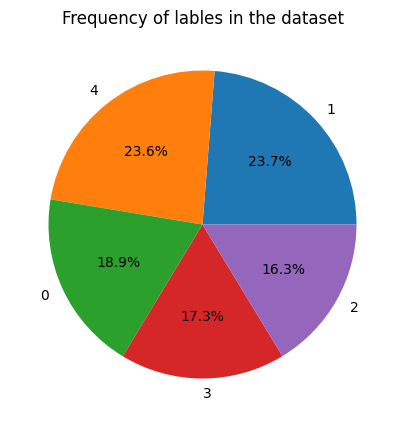

In [6]:
categories = df['Label'].value_counts().reset_index(name='Count')
labels = []
frequencies = []

for i in categories["index"]:
    labels.append(i)

for i in categories["Count"]:
    frequencies.append(i / 2127)

plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.title("Frequency of lables in the dataset")
plt.show()

In [7]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [8]:
import re

def preprocess_text(txt:str):
    txt = re.sub('[^a-zA-Z]', ' ', txt) 
    txt = txt.lower()
    txt = " ".join(txt.split()) 
    
    doc = nlp(txt)
    
    tokens_filtered = []
    # Iterate through tokens and append to list if its not stop word or punctuation mark
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        tokens_filtered.append(token.lemma_)
        
    return " ".join(tokens_filtered)

In [9]:
df['prep_text'] = df['Text'].apply(preprocess_text)
df.head()

,Text,Label,prep_text
0,Budget to set scene for election Gordon Brown...,0,budget set scene election gordon brown seek ec...
1,Army chiefs in regiments decision Military ch...,0,army chief regiment decision military chief ex...
2,Howard denies split over ID cards Michael How...,0,howard deny split d card michael howard deny s...
3,Observers to monitor UK election Ministers wi...,0,observer monitor uk election minister invite i...
4,Kilroy names election seat target Ex-chat sho...,0,kilroy name election seat target ex chat host ...


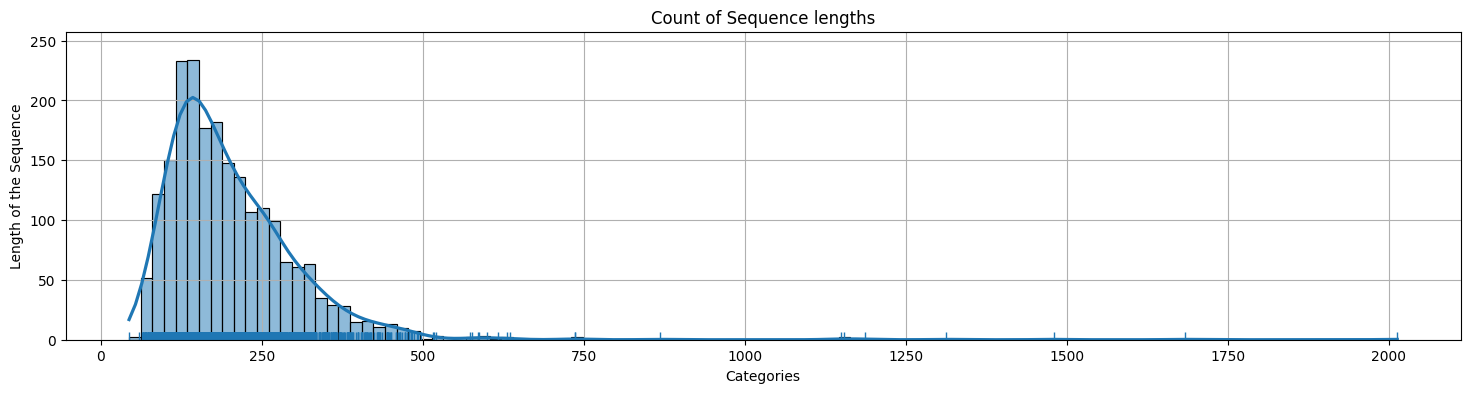

In [10]:
seq_len = []

for txt in df.prep_text:
    seq_len.append(len(txt.split()))
    
plt.figure(figsize = (18, 4))
sns.histplot(seq_len, kde = True, line_kws = {'linewidth': 2.3})
sns.rugplot(seq_len)
plt.title('Count of Sequence lengths')
plt.xlabel('Categories')
plt.ylabel('Length of the Sequence')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words='english')

# Transform preprocessed text into TF-IDF features
features = vectorizer.fit_transform(df['prep_text']).toarray()

In [ ]:
from sklearn.model_selection import train_test_split

X = features
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

print(f'Rows used in training: {len(X_train)}')
print(f'Rows used in evaluation: {len(X_test)}')

In [ ]:
y_train_vals = []
train_labels = []

y_test_vals = []
test_labels = []

for i in range(len(y_train.unique())):
    y_train_vals.append(round(y_train.value_counts()[i]/len(y_train) * 100,2))
    train_labels.append(y_train.unique()[i])

for i in range(len(y_test.unique())):
    y_test_vals.append(round(y_test.value_counts()[i]/len(y_test) * 100,2))
    test_labels.append(y_test.unique()[i])

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=144)

# Plot for training dataset
axs[0].pie(y_train_vals, labels=train_labels, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Training Dataset')

# Plot for test dataset
axs[1].pie(y_test_vals, labels=test_labels, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Test Dataset')

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "LogisiticRegression": {'model':LogisticRegression()},
    "DecisionTreeClassifier": {'model':DecisionTreeClassifier()},
    "Random Forest Classifier": {'model':RandomForestClassifier()},
}

categories = {'Politics':0,'Sport':1, 'Technology':2,'Entertainment':3,'Business':4}

In [ ]:
from sklearn.model_selection import cross_val_score

scores = {}

for key, alg in classifiers.items():
    try:
        alg['model'].fit(X_train, y_train, 
                early_stopping_rounds=10,
                eval_metric='merror',
                eval_set=[(X_test, y_test)])
    except TypeError:
        alg['model'].fit(X_train, y_train)
        
    training_score = cross_val_score(alg['model'], X_train, y_train, cv=5, scoring='accuracy') 
    scores[key] = round(training_score.mean() * 100, 2) 
    
fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(scores.keys(), scores.values())
ax.bar_label(bars, label_type="edge")
plt.ylim(0, 100)
plt.show()

In [ ]:
from sklearn import metrics

classifiers[max(scores, key=scores.get)]['model'].fit(X_train, y_train)
y_pred = classifiers['LogisiticRegression']['model'].predict(X_test)

print('Metrics (Logistic Regression)\n')
print(metrics.classification_report(y_test, y_pred, target_names= categories.keys()))